# Control theory. Course introduction.

## TP1. System modeling. State-space representation of dynamical systems.

## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP2.ipynb)    

The completed notebooks should be sent to your tutor (elena.vanneaux@ensta.fr or adnan.saood@ensta.fr) before the beginning of the next session. Please add [APM_4AUT2_TA] to the topic of e-mail.

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html

## Ex.1: Open-loop vs Closed-loop system

### TODO

Provide one example of open-loop control system and one example of closed-loop control system. What is the difference between them?

## Ex.1: Vehicle Suspension System

Vehicle Suspension System

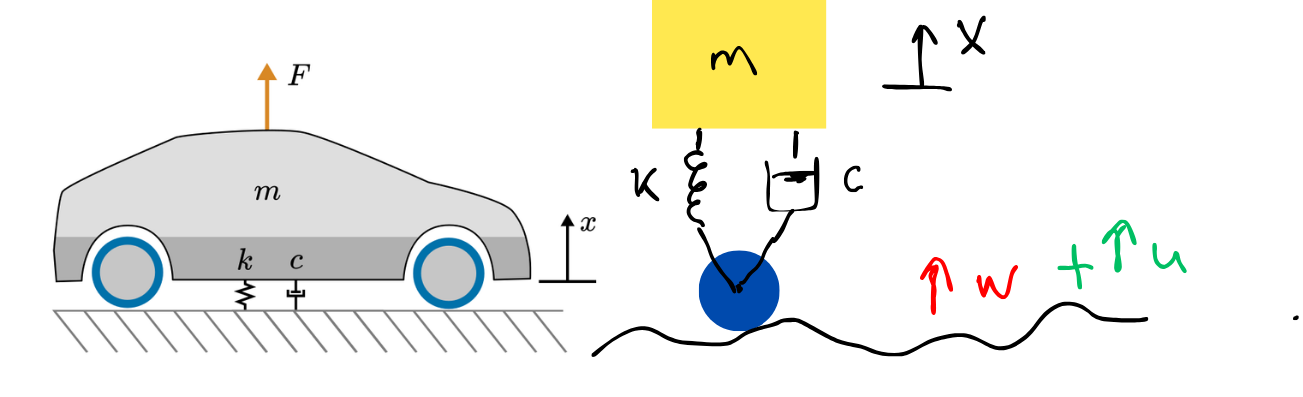

with the following system parameters:

    (m) mass 1.0 kg

    (k) spring constant 5.0 N/m

    $(c)$ damping constant 2 Ns/m

### **Equation of Motion:**

For a mass-spring-damper system, the equation of motion can be derived using Newton's second law or by applying the principles of dynamics. The general form of the equation is:

$$
m \frac{d^2x}{dt^2} + c \frac{dx}{dt} + kx = u + w
$$

### **State-Space Representation:**

To convert the second-order differential equation into a system of first-order differential equations, we introduce the following state variables:
- Let $ x_1 = x $ (position),
- Let $ x_2 = \dot x $ (velocity).

The system becomes:

$$\dot x = Ax+Bu+Dw$$

where
state vector $x = (position, velocity)$, and state and control matrices are the following:
$$ A = \begin{pmatrix} 0&1\\ -\frac{k}{m}&-\frac{c}{m}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix},\ D =\begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix}$$

## TODO
1. Check on the implementation of a bang-bang controller provided below.

The bang-bang controller reduces the displacement when the bump happens, however the output starts to oscillate, and thus the output is not stable because each time, the controller overshoot.

2. Implement a PID controller with parameters Kp = 400, Ki = 200, Kd = 50 that ensures that position of the mass ($y = [1,0]x$) tracks the zero reference input $r(t)=0.$

We start from the basic equations : 
$x = (position, velocity)$
$$\dot x = Ax+Bu+Dw$$
$$ A = \begin{pmatrix} 0&1\\ -\frac{k}{m}&-\frac{c}{m}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix},\ D =\begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix}$$

According to the lecture slides, if we add the PID controller, the system becomes :
$$ \begin{pmatrix} \dot x\\ \dot z \end{pmatrix} = A_a \begin{pmatrix}x\\ z \end{pmatrix} + B_a r + B_{ad} \dot r + D_a w  $$
$$ y = C_a \begin{pmatrix} x\\ z \end{pmatrix}$$

With $A_a = \begin{pmatrix} M^{-1} (A - K_p BC) & -M^{-1} K_i B \\ C & 0 \end{pmatrix} $, $ B_a = \begin{pmatrix}K_p M^{-1} B\\-1 \end{pmatrix} $, $B_{ad} = \begin{pmatrix}K_d M^{-1} B\\0 \end{pmatrix} $, $D_a =  \begin{pmatrix}M^{-1} C \\0 \end{pmatrix} $, $C_a = \begin{pmatrix} C & 0 \end{pmatrix}$ and $z = \int_0^t (y(s) - r(s) )ds $ with $M = I + K_d BC$

3. Let $x_0 = (0, 0).$ Let disturbance input $w(t)$ is given by a step function
    $$w = \left\{\begin{aligned}
        &0, \quad t <3.0\\
        &1.0,  \quad 3.0 \leq t < 7.0\\
        &0,  \quad t \geq 7
    \end{aligned}\right.$$
   Comparer the trajectories of uncontrolled ($u(t) = 0$) and controlled (with bang-bang and with PID controllers correnspondingly) systems.

The PID controlled system is a lot more stable than all the other ones.

In [116]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    return (C @ solution.T) 

def BangBangController(A, B, D, C, u_const, ref, delay, w_func, T, x0):
    y_res = np.empty(x0.shape).reshape(-1,1)
    t0 = 0
    t1 = delay
    while t1 < T[-1]+delay:
        # Extract time segment
        T_bang = T[T<=t1]
        T = T[T_bang.shape[0]-1:]
        # Bang-Bang control logic
        u_func = lambda t: -u_const if C @ x0 - ref > 0 else (u_const if C @ x0 - ref < 0 else 0.0)
        # Compute system response
        sol = odeint(StateSpace, x0, T_bang, args=(A, B, D, u_func, w_func)).T
        x0 = sol[:,-1].flatten()
        # Update variables
        t0 = t1
        t1 += delay
        y_res = np.hstack((y_res, sol[:,1:]))
    return C @ y_res

def stateSpacePID(X, t, A, B, D, C, r_func, rDot_func, w_func, Kp, Ki, Kd):
    # X = [[x], [z]]
    # Definition of the matrices
    BC = B@C
    M = np.eye(BC.shape[0]) + Kd * BC
    M_inv = np.linalg.inv(M)

    Aa_top_left = M_inv @ (A - Kp * BC)
    Aa_top_right = -Ki * M_inv @ B
    Aa_bot_left = C 
    Aa_bot_right = np.zeros((C.shape[0], (M_inv@B).shape[1]))
    Aa = np.vstack((np.hstack((Aa_top_left, Aa_top_right)), 
                    np.hstack((Aa_bot_left, Aa_bot_right)) ))

    Ba = np.vstack((Kp * M_inv @ B, 
                    -np.eye(B.shape[1])))

    Bad = np.vstack((Kd* M_inv @ B, 
                     np.zeros(B.shape[1])))

    Da = np.vstack((M_inv @ D, np.zeros(D.shape[1])))

    # Definition of the target and the perturbation
    w = w_func(t)
    r = r_func(t)
    rDot = rDot_func(t)

    return np.dot(Aa, X) + np.dot(Ba, r).flatten() + np.dot(Bad, rDot).flatten() + np.dot(Da, w).flatten()

# We do the PID controller
def PIDController(A, B, D, C, r_func, rDot_func, w_func, Kp, Ki, Kd, T, x0):
    # Calculate the solution 
    solution = odeint(stateSpacePID, x0, T, args=(A, B, D, C, r_func, rDot_func, w_func, Kp, Ki, Kd))
    # Return the solution
    return solution

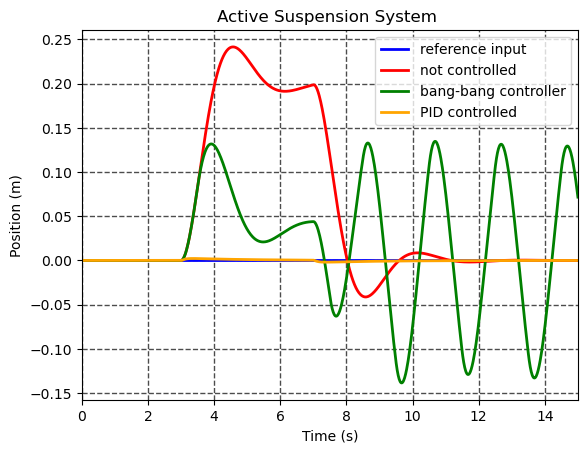

In [117]:
# System parameters
m = 1
k = 5
c = 2
g = 9.8

A = np.array([[0, 1],
              [-k/m, -c/m]])  # Corrected c instead of rho

B = np.array([[0],
              [1/m]])  # Reshaped to column vector
D = np.array([[0],
              [1/m]])  # Reshaped to column vector

C = np.array([[1, 0]])  # Output matrix

R = np.array([0])

# flatten() to convert to 1D array since scipy.integrate.odeint requires the state vector (x) to have shape (n,), not (n,1).
x0 = np.array([0, 0]).flatten() # Initial state

# Time settings
t0 = 0  # Initial time 
tf = 15# Final time
T = np.linspace(t0, tf, 1000)  # Time vector

def w_func(t):
    if t<= 3.0:
        return 0.0
    elif 3.0<= t and t<7.0:
        return 1.0
    else:
       return 0.0# Disturbance input
        

########################## BangBang ##########################

# Compute system response
u_const = 0.8
delay = 0.5
x_ref = 0.0
yBangBang =  BangBangController(A, B, D, C, u_const, x_ref, delay, w_func, T, x0)


########################## Open Loop ##########################

def u_func(t):
    return 0.0

yOpenLoop = OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0)



########################## PID ##########################
# Plot the PID controlled system
Kp = 400
Ki = 200
Kd = 50
def r_func(t):
    return 0
def rDot_func(t):
    return 0

x0 = np.array([[0], [0], [0]]).flatten()    # Need to make the initial values 3*1


yPID = PIDController(A, B, D, C, r_func, rDot_func, w_func, Kp, Ki, Kd, T, x0)

########################## Plot all data ##########################

plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.7)
plt.xlim([t0, tf])
plt.ylabel(r'Position (m)')
plt.xlabel('Time (s)')
plt.title('Active Suspension System ')
plt.plot(T, T* 0, linewidth=2.0, color='blue')
plt.plot(T, yOpenLoop[0,:], linewidth=2.0, color='red')
plt.plot(T, yBangBang[0,:], linewidth=2.0, color='green')
plt.plot(T, yPID[:,0], linewidth=2.0, color='orange')
plt.legend(['reference input', 'not controlled','bang-bang controller', 'PID controlled' ])
plt.show()    

## DC Motor Speed: System Modeling

A common actuator in control systems is the DC motor. It directly provides rotary motion and, coupled with wheels or drums and cables, can provide translational motion. The electric equivalent circuit of the armature and the free-body diagram of the rotor are shown in the following figure.

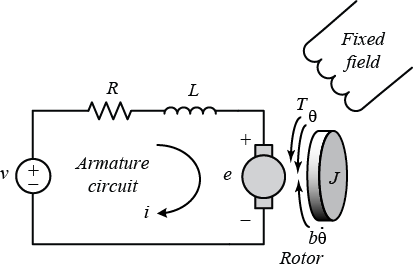

For this example, we will assume that the input of the system is the voltage source ($V$) applied to the motor's armature, while the output is the rotational speed of the shaft $\dot{\theta}$. The rotor and shaft are assumed to be rigid. We further assume a viscous friction model, that is, the friction torque is proportional to shaft angular velocity. We will assume that the magnetic field is constant and, therefore, that the motor torque is proportional (with constant $K_t$) to only the armature current. Let us remark that in SI units the motor torque and back emf constants are equal, that is, $K_t = K_e$;

The physical parameters for our example are:

    (J)   moment of inertia of the rotor     0.01 kg.m^2

    (b)     motor viscous friction constant    0.1 N.m.s

    (Ke)    electromotive force constant       0.01 V/rad/sec

    (Kt)    motor torque constant              0.01 N.m/Amp

    (R)     electric resistance                1 Ohm

    (L)     electric inductance                0.5 H
    

Let us suppose that the measured output of the system is the angular velocity of the rotor $\dot{\theta}$ and the current intensity $\dot{i}$. Then the state space model of the system is the following:
$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x=(\dot{\theta}, i)$, control vector $u=V$, and state and control matrices are the following

$$ A = \begin{pmatrix} -\frac{b}{J}&\frac{K}{J}\\ -\frac{K}{L}&-\frac{R}{L}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{L} 
\end{pmatrix}$$

Let us suppose that we only interested in rotation speed (angular velocity of the rotor), i.e. $C=(1,0)$.

## TODO

1. For a 1-rad/sec step reference, the design a PID controller that satisfies the following criteria are the following.

    Settling time less than 2 seconds

    Overshoot less than 5%

    Steady-state error less than 1%
   
3. Tune a PID controller using the Ziegler-Nichols Methods.

In [157]:
############## Define the values ##############
# System parameters
J = 0.01
b = 0.1
K = 0.01    # Kt = Kl = K
R = 1
L = 0.5

def u_func(t):
    V = 1
    return V

def w_func(t):
    return 0

# Matrices
A = np.array([[-b/J, K/J],
              [-K/L, -R/L]])
B = np.array([[0],
              [1/L]])
D = np.array([[0],
              [0]])  # Reshaped to column vector
C = np.array([[1, 0],[0,1]])  # Output matrix

x0 = np.array([0, 0]).flatten() # Initial state

t0 = 0
tf = 5
T = np.linspace(t0, tf, 10000)

### First method

Duration L : 0.05349423750692677
Duration T : 0.7470858204988738
Kp : 16.75887023312677
Ki : 1.0
Kd : 0.25


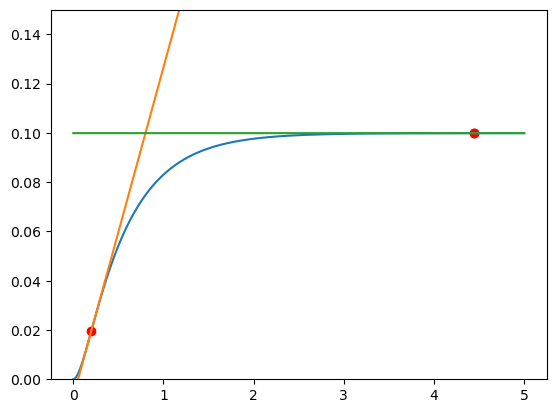

In [155]:
############## Open Loop System ##############
y = OpenLoopInputOutputSystem(A,B,D,C,u_func,w_func,T,x0)
y = y[0,:]

plt.plot(T, y)

############## Calculating the PID values ##############
# Derivatives
yDot = np.gradient(y, T)
yDotDot = np.gradient(yDot, T)

# Inflection point
inflection_points = np.where(np.diff(np.sign(yDotDot)))[0]
plt.scatter(T[inflection_points], y[inflection_points], color='red')

# Tangent at the inflection point
inflection_points = inflection_points[0]
coeff_dir = yDot[inflection_points]
ordo_origin = y[inflection_points] - coeff_dir*T[inflection_points]
def tangentEquation(t):
    return coeff_dir*t + ordo_origin

# Plot the different lines
tangent = tangentEquation(T)
plt.plot(T, tangent)
plt.plot(T,[y[-1]]*len(T))
plt.ylim(0, 0.15)

# Search for L
LPID = -ordo_origin/coeff_dir
print("Duration L :", LPID)

# Search for T 
final_value = y[-1]
i = 0
while(tangent[i]<final_value):
    i = i + 1
TPID = T[i] - LPID
print("Duration T :", TPID)


# Creating the PID values
Kp1 = 1.2 * TPID / LPID
Ki1 = 2 * L
Kd1 = L / 2

print("Kp :", Kp1)
print("Ki :", Ki1)
print("Kd :", Kd1)


### Second method

In [158]:
############## Setup ##############
Kp = 0

while(Kp < 20):
    y = PIDController(A,B,D,C,r_func,rDot_func,w_func,Kp,0,0,T,x0)
    y = y[0,:]
    plt.plot(T, y)
    Kp = Kp + 0,1




ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

## EX. 3 Inverted Pendulum

The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.

![inverted_pendulum.png](attachment:0a81c6f5-4431-4bf0-a50c-133da7e550cc.png)

Let us consider the system with the following system parameters
    
    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

## TODO
    
The inverted pendulum on the cart can be modeled as follows

$$(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta -ml\dot\theta^2\sin(\theta) = F$$

$$ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0$$    

1. Check on the code below showing that a linearalised model of the system is the following

$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x = (y,\theta,\dot{y},\dot{\theta})$, control vector $u=F$.

$$\left[\begin{array}{c}\dot{y} \\ \dot{\theta} \\ \ddot{y} \\ \ddot{\theta}\end{array}\right]=
\left[\begin{array}{cccc}0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 1 \\ 
0 & \frac{-g m^2 l^2}{I(M+m)+M m l^2} & \frac{-\left(I+m l^2\right) b}{I(M+m)+M m l^2} & 0 \\ 
0 & \frac{m g l(M+m)}{I(M+m)+M m l^2} & \frac{m l b}{I(M+m)+M m l^2} & 0\end{array}\right]
\left[\begin{array}{c}y \\ \theta \\ \dot{y} \\ \dot{\theta}\end{array}\right]+
\left[\begin{array}{c}0 \\ 0 \\ \frac{I+m l^2}{I(M+m)+M m l^2} \\ \frac{-m l}{I(M+m)+M m l^2}\end{array}\right] u$$

$$
\mathbf{y}=
\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]
\left[\begin{array}{c}y \\ \theta \\ \dot{y} \\ \dot{\theta}\end{array}\right]$$

3) Design a PID controller corresponding to the reference signal $\theta_{ref}$ = 0 rad, while supposing that the angle is subject to a constant disturbance $w(t) = 0.1$

4) Plot the position of the cart for the corresponding closed-loop system. What conclusion could you make?

In [118]:
import sympy as sp
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))